In [173]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
import bambi
import pymc as pm
import arviz as az

In [136]:
def clean_data(filename):
    try:
        data = pd.read_csv('data/' + filename)
        # Drop instruction rows by dropping rows with missing data in column: 'blocks.thisRepN'
        data = data.dropna(subset=['blocks.thisRepN']).reset_index(drop=True)

        #Compute accuracy as True if number of response values are the same as number of stim values
        # print(data['stim'])
        data['accuracy'] = [True if (len(ast.literal_eval(data['stim'][i])) == len(ast.literal_eval(data['key_resp.rt'][i]))) else False for i in range(len(data))]


        data['node_type'] = ['Boundary' if data['node idx'][i] in [0, 4, 5, 9, 10, 14] else 'Non Boundary' for i in range(len(data))]

        data['rt'] = [np.mean(ast.literal_eval(data['key_resp.rt'][i])) if data['accuracy'][i] else np.NaN for i in range(len(data))]
        data['transition_type'] = ['cross cluster' if (data['node_type'] == 'Boundary')[i] & (data['node_type'].shift() == 'Boundary')[i] else 'within cluster' for i in range(len(data))]

        if data['participant'][0]%4 == 0:
            data['hop_length'] = 0
        elif data['participant'][0]%4 == 1:
            data['hop_length'] = 3
        elif data['participant'][0]%4 == 2:
            data['hop_length'] = 6
        else:
            data['hop_length'] = 1400

        data['trial'] = np.arange(len(data))
    except:
        return None


    return data[['participant', 'trial', 'blocks.thisRepN', 'accuracy', 'hop_length', 'node_type', 'transition_type', 'rt']]


In [151]:
data_files = []
for f in os.listdir('data/'):
    if (f.startswith('30') & f.endswith('csv')):
        data_files.append(f)

In [152]:
df_clean = pd.concat([clean_data(f) for f in data_files])


In [153]:
df_clean

,participant,trial,blocks.thisRepN,accuracy,hop_length,node_type,transition_type,rt
0,3000.0,0,0.0,True,0,Boundary,within cluster,1.367459
1,3000.0,1,0.0,False,0,Non Boundary,within cluster,NaN
2,3000.0,2,0.0,True,0,Boundary,within cluster,1.377622
3,3000.0,3,0.0,True,0,Non Boundary,within cluster,1.171814
4,3000.0,4,0.0,True,0,Boundary,within cluster,1.230127
...,...,...,...,...,...,...,...,...
1395,3002.0,1395,6.0,True,6,Boundary,within cluster,0.616282
1396,3002.0,1396,6.0,True,6,Non Boundary,within cluster,0.540360
1397,3002.0,1397,6.0,True,6,Non Boundary,within cluster,0.976394
1398,3002.0,1398,6.0,True,6,Boundary,within cluster,0.504482


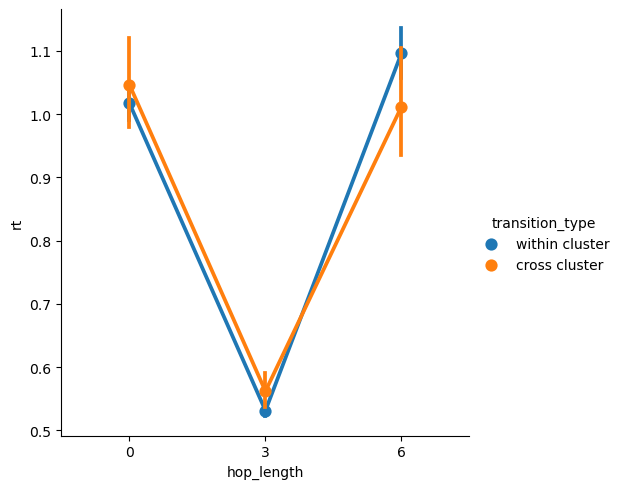

In [170]:
sns.catplot(y = 'rt', 
            x = 'hop_length', hue = 'transition_type', #col = 'node_type',
            kind = 'point',
            data=df_clean)